# 5단계 - 비전 모델과 자연어 기반 검색 시스템 연계

## 5.1 라이브러리 설치 및 모델 로드

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoModel, AutoTokenizer
from ultralytics import YOLO

# 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Jina-CLIP-v2 모델 로드
# Jina-CLIP-v2 모델은 한국어 완벽하게 지원해서 선정.
model_id = "jinaai/jina-clip-v2"

print(f"모델 로딩 시도: {model_id}")

try:
    model = AutoModel.from_pretrained(model_id, trust_remote_code=True).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    print("Jina-CLIP-v2 로드 성공.")
except Exception as e:
    print(f"모델 로드 중 오류 발생: {e}")

# 2. 4단계에서 학습한 YOLOv8 모델의 가중치 로드
yolo_path = '/home/ssy/maple-vision-search/notebook/maple_yolo/pose_detection_v1/weights/best.pt'
yolo_model = YOLO(yolo_path)

print(f"최종 준비 완료. (Device: {device})")

모델 로딩 시도: jinaai/jina-clip-v2
Jina-CLIP-v2 로드 성공.
최종 준비 완료. (Device: cuda)


## 5.2 Vector DB 구축

In [60]:
import os
import pandas as pd
import numpy as np
import torch
import faiss
from PIL import Image
from tqdm.auto import tqdm

def build_vector_db_from_processed(root_path, index_save_path, csv_save_path):
    # 1. 경로 설정
    crop_dir = f'{root_path}/data/processed/temp_crop'
    label_dir = f'{root_path}/data/processed/temp_label'
    
    # 크롭된 이미지 리스트 확보
    crop_files = sorted([f for f in os.listdir(crop_dir) if f.endswith('.jpg')])
    
    metadata = []
    embeddings = []
    
    # 모델 추론 모드
    model.eval()

    # 1단계에서 정의한 포즈 인덱스 매핑
    # 3단계 auto_labeling.ipynb에서 저장한 txt 내용이 인덱스 번호라고 가정
    class_names = ["fly", "jump", "prone", "shoot1", "stabO1", "stand1", "stand2", "swingO1", "walk1", "walk2"]

    for crop_name in tqdm(crop_files, desc="가공 데이터 임베딩 중"):
        crop_path = os.path.join(crop_dir, crop_name)
        
        # 파일명 매칭을 통해 라벨(txt) 경로 생성 (예: image_1_0.png -> image_1_0.txt)
        label_name = os.path.splitext(crop_name)[0] + '.txt'
        label_path = os.path.join(label_dir, label_name)
        
        if not os.path.exists(label_path):
            continue
            
        # 2. 이미지 로드 및 임베딩
        img = Image.open(crop_path).convert("RGB")
        with torch.no_grad():
            img_emb = model.encode_image(img)
            # L2 정규화 (Cosine Similarity 준비)
            img_emb = img_emb / np.linalg.norm(img_emb, axis=-1, keepdims=True)
        
        # 3. 라벨 읽기 (3단계 auto_labeling 결과물)
        with open(label_path, 'r') as f:
            class_idx = int(f.read().strip())
        
        embeddings.append(img_emb.flatten())
        metadata.append({
            'crop_name': crop_name,
            'image_path': crop_path, 
            'class_id': class_idx,
            'class_name': class_names[class_idx]
        })

    # 4. Faiss 인덱싱
    if embeddings:
        embeddings_np = np.array(embeddings).astype('float32')
        index = faiss.IndexFlatIP(embeddings_np.shape[1])
        index.add(embeddings_np)
        
        # 저장 폴더 생성 확인
        os.makedirs(os.path.dirname(index_save_path), exist_ok=True)
        
        faiss.write_index(index, index_save_path)
        pd.DataFrame(metadata).to_csv(csv_save_path, index=False)
        print(f"\nDB 구축 완료: {len(metadata)}개 가공 객체 인덱싱됨.")

# 실행
root = '/home/ssy/maple-vision-search'
build_vector_db_from_processed(
    root, 
    f'{root}/data/processed/maple_jina.index', 
    f'{root}/data/processed/maple_metadata.csv'
)

가공 데이터 임베딩 중: 100%|██████████| 1467/1467 [02:39<00:00,  9.20it/s]


DB 구축 완료: 1467개 가공 객체 인덱싱됨.


---

## 5.3 클래스 라벨 텍스트 데이터 임베딩

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from PIL import Image

# 10개 클래스 정의 (서영님의 실제 순서에 맞게 수정 필수)
class_names = ["fly", "jump", "prone", "shoot1", "stabO1", "stand1", "stand2", "swingO1", "walk1", "walk2"]

# 클래스 라벨 임베딩 사전 구축
class_embeddings = {}
model.eval()
with torch.no_grad():
    for name in class_names:
        emb = model.encode_text(name)
        emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)
        class_embeddings[name] = emb.flatten()

print("클래스 라벨 임베딩 완료.")

클래스 라벨 임베딩 사전 구축 완료.


## 5.4 2단계 유사도 계산 기반 로직 자동화 함수 정의 (Re-ranker)

### 1. 문제 인식 (Problem Recognition)

* **도메인 간극**: 사전 학습된 CLIP 모델은 실사 이미지 위주로 학습되어 있어, 메이플스토리와 같은 **2D 픽셀 아트의 추상적인 포즈 특징**을 추출하는 데 취약함.
* **정확도 저하**: 사용자의 자연어 쿼리와 캐릭터 이미지 간의 시각적 유사도만으로는 검색 결과의 신뢰도를 보장할 수 없음.

### 2. 해결 과정 (Thought Process)

* **사전에 만든 데이터 활용**: 프로젝트의 4단계에서 직접 구축하여 80% 이상의 정확도를 확보한 **YOLOv8/MobileNet의 포즈 라벨 데이터**를 시스템의 판단 근거로 추가함.
* **리랭킹 로직 고안 **: 단순히 이미지 데이터 - 텍스트 데이터 간 유사도로 검색 결과를 출력하는 게 아닌, 텍스트 데이터(쿼리) - 텍스트 데이터(라벨) 간 유사도 계산 단계를 추가해 시스템 신뢰도를 높임.

### 3. 리랭킹 로직 요약 (Logic Summary)

1. **Stage 1 (텍스트 데이터 - 이미지 데이터 간 유사도 계산)**: 텍스트 데이터(입력 쿼리) - 이미지 데이터(크롭 이미지) 벡터 간의 유사도를 계산하여 전체 데이터 중 상위 개의 후보군을 1차로 추출함.
2. **Stage 2 (텍스트 데이터 - 텍스트 데이터 간 유사도 계산)**: 추출된 후보군에 대해 '쿼리 텍스트'와 '포즈 라벨 텍스트' 간의 유사도를 추가 계산함.
3. **최종 정렬**: 두 유사도 점수를 가중치에 따라 합산하여 Score를 구해 최종 순위를 결정하고 상위 개를 출력함.

### 4. 최종 점수(Score) 계산 공식

$$Score = \alpha \cdot Sim(T_{query}, I_{img}) + (1 - \alpha) \cdot Sim(T_{query}, T_{label})$$

* $Sim(T_{query}, I_{img})$: 쿼리와 캐릭터 크롭 이미지 간의 시각적 유사도 (ImgSim).
* $Sim(T_{query}, T_{label})$: 쿼리와 클래스 라벨 간의 텍스트 유사도 (TxtSim).
* $alpha$ : 이미지 데이터 반영 비중을 결정하는 가중치 (0~1).



In [ ]:
def search_re_ranker(query, k=3, alpha=0.5):
    # alpha: 이미지 유사도(CLIP)와 텍스트 유사도(Label 매칭)의 반영 비율 (0~1)
    root_path = '/home/ssy/maple-vision-search'
    index_path = f'{root_path}/data/processed/maple_jina.index'
    csv_path = f'{root_path}/data/processed/maple_metadata.csv'
    
    # 인덱스 및 메타데이터 로드
    index = faiss.read_index(index_path)
    metadata = pd.read_csv(csv_path)
    
    # 1. 쿼리 임베딩
    with torch.no_grad():
        query_emb = model.encode_text(query)
        if torch.is_tensor(query_emb):
            query_emb = query_emb.cpu().numpy()
            
        # 정규화 및 Faiss용 차원 변환 (1, D)
        query_emb = query_emb / np.linalg.norm(query_emb, axis=-1, keepdims=True)
        query_emb_np = query_emb.astype('float32').reshape(1, -1)

    # 2. Stage 1: 이미지-텍스트 유사도 기반 후보 추출 (10 * k개)
    candidate_count = min(10 * k, len(metadata))
    distances, indices = index.search(query_emb_np, candidate_count)
    
    # 3. Stage 2: 텍스트-텍스트 유사도 계산 및 리랭킹
    re_ranked_results = []
    for i in range(candidate_count):
        idx = indices[0][i]
        img_sim = distances[0][i] 
        row = metadata.iloc[idx]
        
        label_name = row['class_name']
        label_emb = class_embeddings[label_name]
        
        text_sim = np.dot(query_emb_np.flatten(), label_emb)
        
        # 최종 점수 산출
        final_score = (alpha * img_sim) + ((1 - alpha) * text_sim)
        re_ranked_results.append((final_score, img_sim, text_sim, row))

    # 4. 최종 정렬 및 k개 선택
    re_ranked_results.sort(key=lambda x: x[0], reverse=True)
    final_k = re_ranked_results[:k]

    # 5. 결과 시각화 및 원본 파일명 출력
    plt.figure(figsize=(18, 6))
    for i, (score, i_sim, t_sim, row) in enumerate(final_k):
        # 크롭 이미지 열기
        img = Image.open(row['image_path']).convert("RGB")
        
        # 원본 파일명 파싱: 'image_1_0.png' -> 'image_1.png'
        # '_'를 기준으로 나누어 마지막 인덱스만 제외하고 다시 합침
        crop_name = row['crop_name']
        parts = crop_name.split('_')
        raw_filename = "_".join(parts[:-1]) + ".png" # 원본이 png라고 가정
        
        plt.subplot(1, len(final_k), i+1)
        plt.imshow(img)
        
        # 타이틀에 원본 파일명(Raw File) 정보 추가
        title = (f"Rank {i+1} (Score: {score:.4f})\n"
                 f"Raw Game Screen Image File Path: {raw_filename}\n"
                 f"Sim: Img({i_sim:.2f}), Txt({t_sim:.2f})\n"
                 f"Label: {row['class_name']}")
        
        plt.title(title, fontsize=9)
        plt.axis('off')
        
        # 콘솔에도 파일명 정보 출력
        print(f"[Rank {i+1}] 원본 파일명: {raw_filename} | 포즈: {row['class_name']} | 점수(Score): {score:.4f}")
    
    plt.suptitle(f"Result | Query: '{query}' (alpha={alpha})", fontsize=16, y=1.08)
    plt.tight_layout()
    plt.show()

## 5.5 실행 예시(쿼리를 달리하며 Score와 Simularity 비교)

In [119]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

[Rank 1] 원본 파일명: 414d1902-bd43-4973-b4af-a886d5bbb99a.png | 포즈: prone | 점수: 0.5494
[Rank 2] 원본 파일명: 9b685b48-1403-4e9b-8cc1-2791191e11c6.png | 포즈: prone | 점수: 0.5471
[Rank 3] 원본 파일명: e4693c4d-4977-48e3-bbd5-238d64c66e41.png | 포즈: jump | 점수: 0.4717


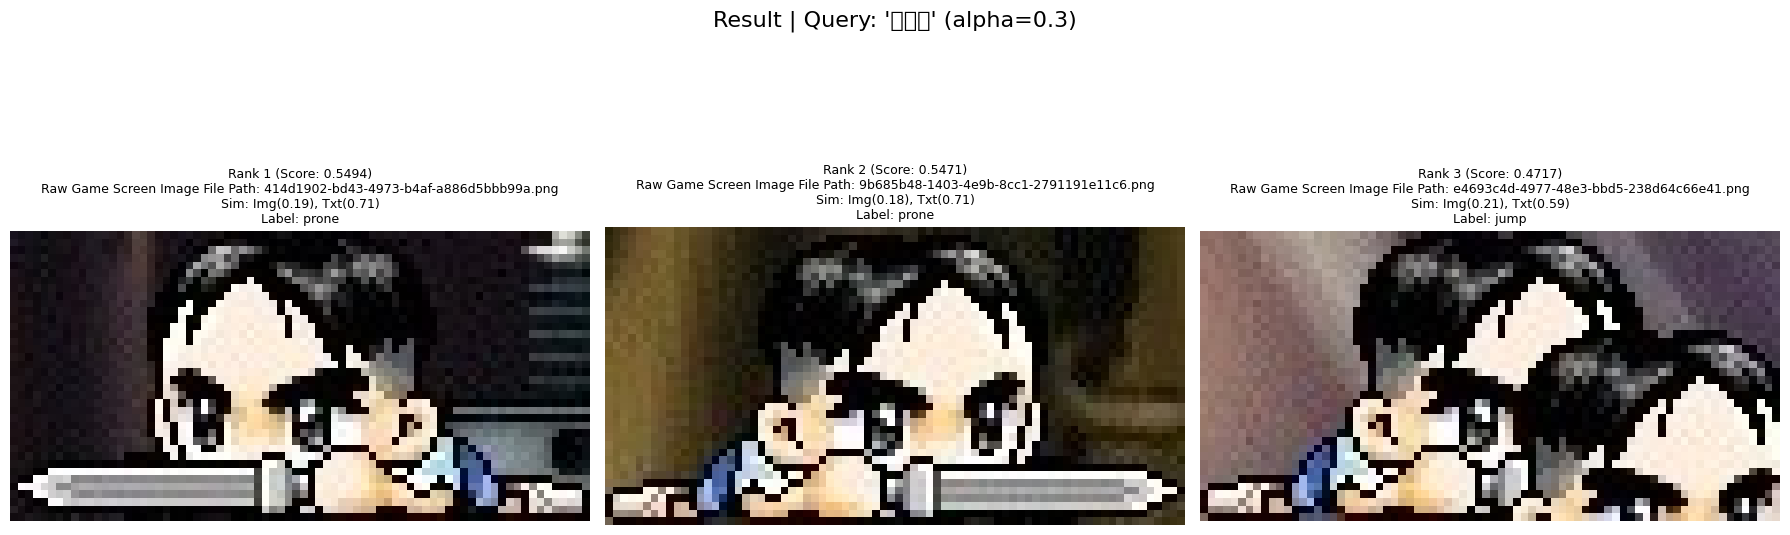

In [ ]:
# 실험 1 : 쿼리를 한글로 입력하고, 텍스트 데이터 유사도 비중을 이미지 데이터 유사도 비중 alpha 보다 높임(alpha=0.3)

# 텍스트 유사도에 70% 가중치를 주어 'prone' 라벨을 가진 이미지가 우선적으로 나오게 함
    # 이유 : 실제 사진으로 훈련 된 CLIP 모델이 2d 픽셀 이미지 데이터의 유사도 계산에 취약하므로, 
    # 텍스트 데이터의 유사도에 더 높은 비중을 두는 것이 효과적일 수 있다고 판단함.
search_re_ranker("엎드린", k=3, alpha=0.3)

결과 분석 : Score는 0.5점대, ImgSim은 0.2점대로 매우 낮으며 실제 이미지 기반으로 훈련된 CLIP 모델이 2d 캐릭터 이미지 데이터의 유사도 계산에 취약함을 알 수 있다. TxtSim은 0.59점~0.7점대를 상회하며, 다중 언어(한국어 및 영어)에 기반한 jina_CLIP 모델의 특성처럼 텍스트 유사도가 비교적 높음을 알 수 있다.

[Rank 1] 원본 파일명: 74dddc17-4c1c-44ae-a8d4-985da57a6a5c.png | 포즈: jump | 점수: 0.4691
[Rank 2] 원본 파일명: 1c15c7da-d244-4cc2-aa61-3d9678b892d3.png | 포즈: jump | 점수: 0.4674
[Rank 3] 원본 파일명: 19d4065e-8b1b-42c4-9965-026bd4d00ad2.png | 포즈: walk1 | 점수: 0.4668


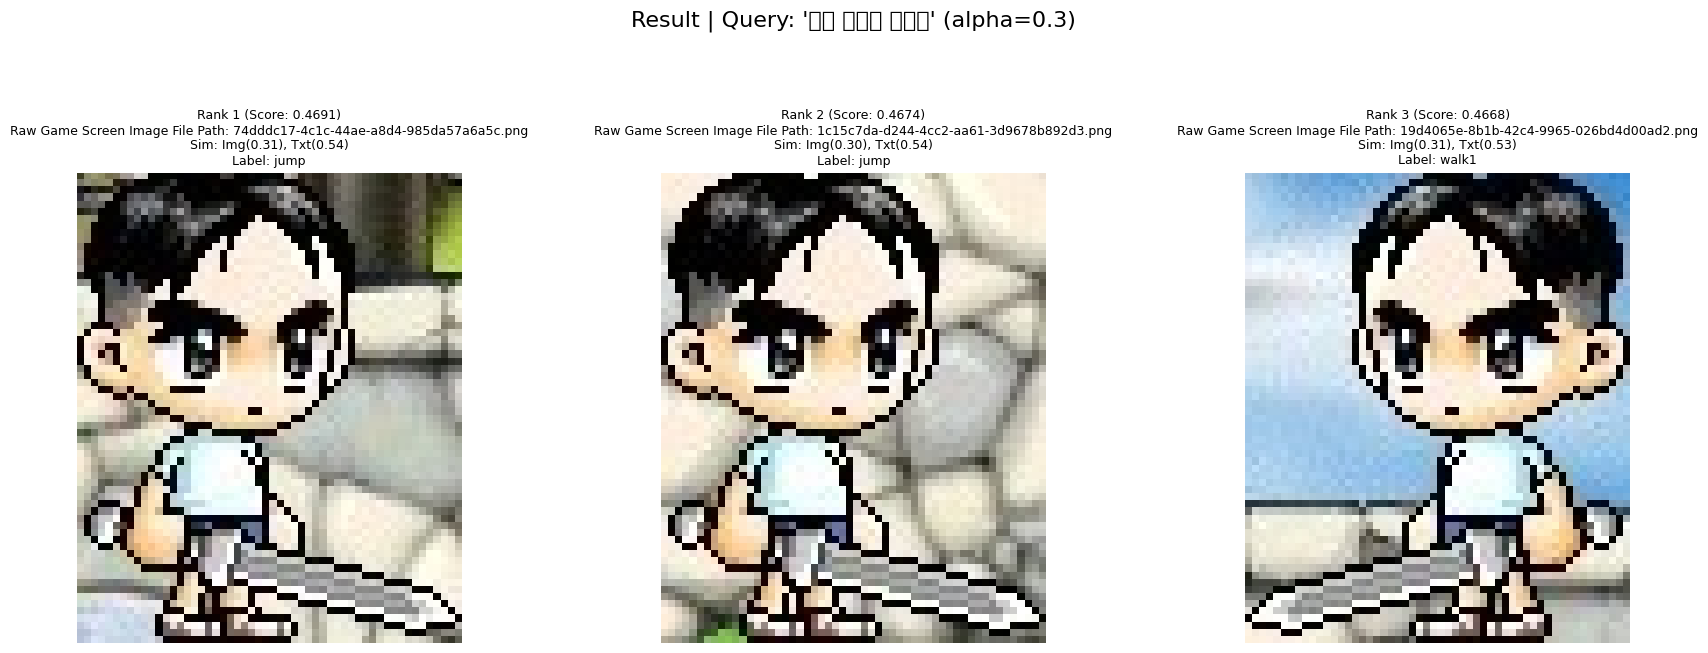

In [ ]:
# 실험 2 : 쿼리를 한글로 입력하지만 라벨 텍스트와 의미 없는 미사여구를 추가함. 그 외 조건은 예시 1과 동일
search_re_ranker("땅에 엎드린 캐릭터", k=3, alpha=0.3)

결과 분석 : TxtSim 값이 0.7 점 대였던 예시 1과 달리, 텍스트 유사도가 낮은 미사여구를 쿼리에 추가해서 0.5점대로 떨어졌고 score도 0.1%p 줄어들었다.

[Rank 1] 원본 파일명: 9b685b48-1403-4e9b-8cc1-2791191e11c6.png | 포즈: prone | 점수: 0.7657
[Rank 2] 원본 파일명: 414d1902-bd43-4973-b4af-a886d5bbb99a.png | 포즈: prone | 점수: 0.7656
[Rank 3] 원본 파일명: bea93ffc-83c4-428b-8cab-4b95f265645f.png | 포즈: jump | 점수: 0.5596


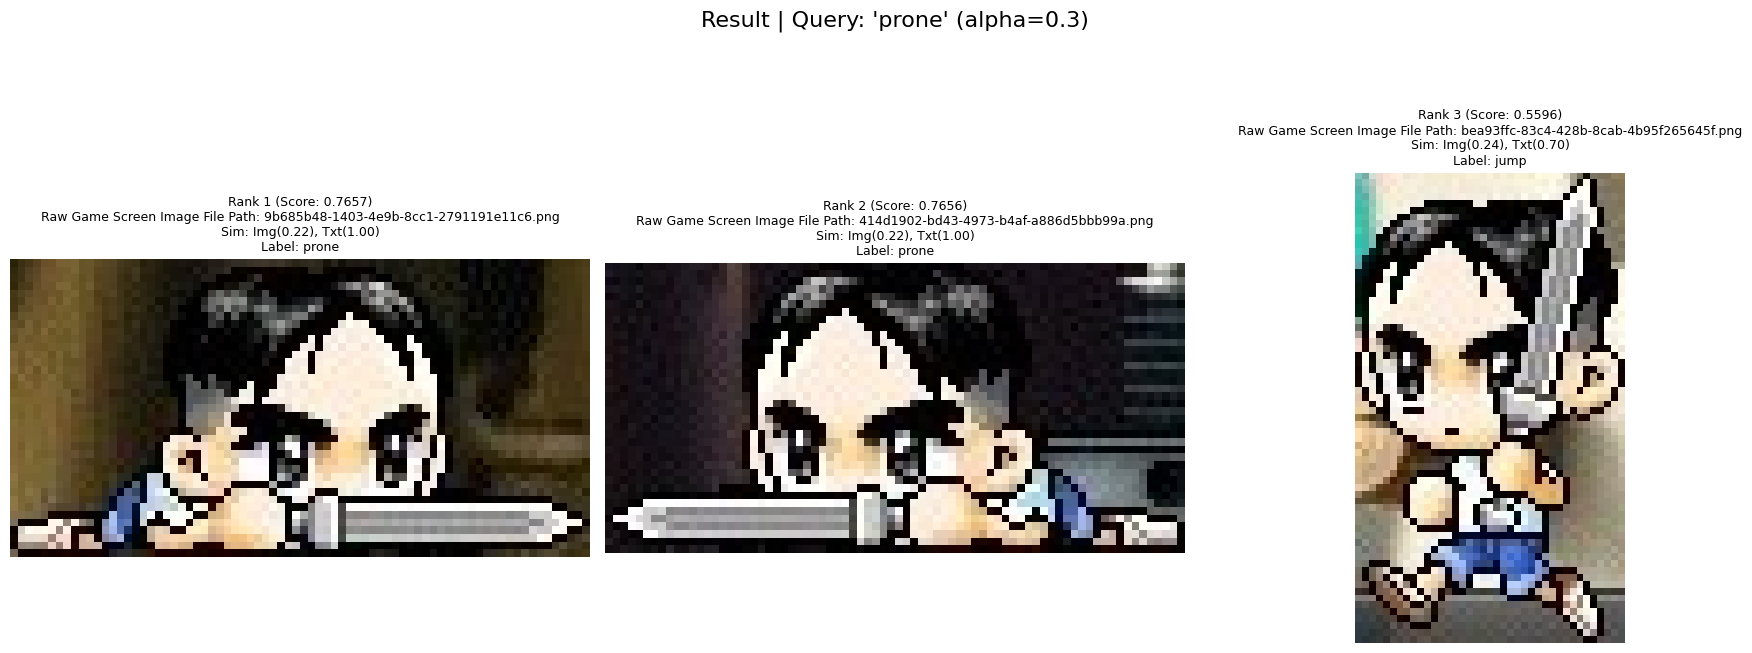

In [ ]:
# 실험 3 : 쿼리를 영어로 입력하고, 텍스트 유사도 비중을 높임(alpha=0.3)
search_re_ranker("prone", k=3, alpha=0.3)

결과 분석 : 쿼리 텍스트가 라벨 텍스트에 대해 언어부터 내용까지 완벽히 동일하므로 TxtSim이 1에 가까운 값으로 매우 높게 나오고, 텍스트 데이터의 유사도 비중을 0.7로 크게 줬기에 score가 0.7점 대로 높음을 알 수 있음.

[Rank 1] 원본 파일명: 9b685b48-1403-4e9b-8cc1-2791191e11c6.png | 포즈: prone | 점수: 0.4533
[Rank 2] 원본 파일명: 414d1902-bd43-4973-b4af-a886d5bbb99a.png | 포즈: prone | 점수: 0.4530
[Rank 3] 원본 파일명: bea93ffc-83c4-428b-8cab-4b95f265645f.png | 포즈: jump | 점수: 0.3790


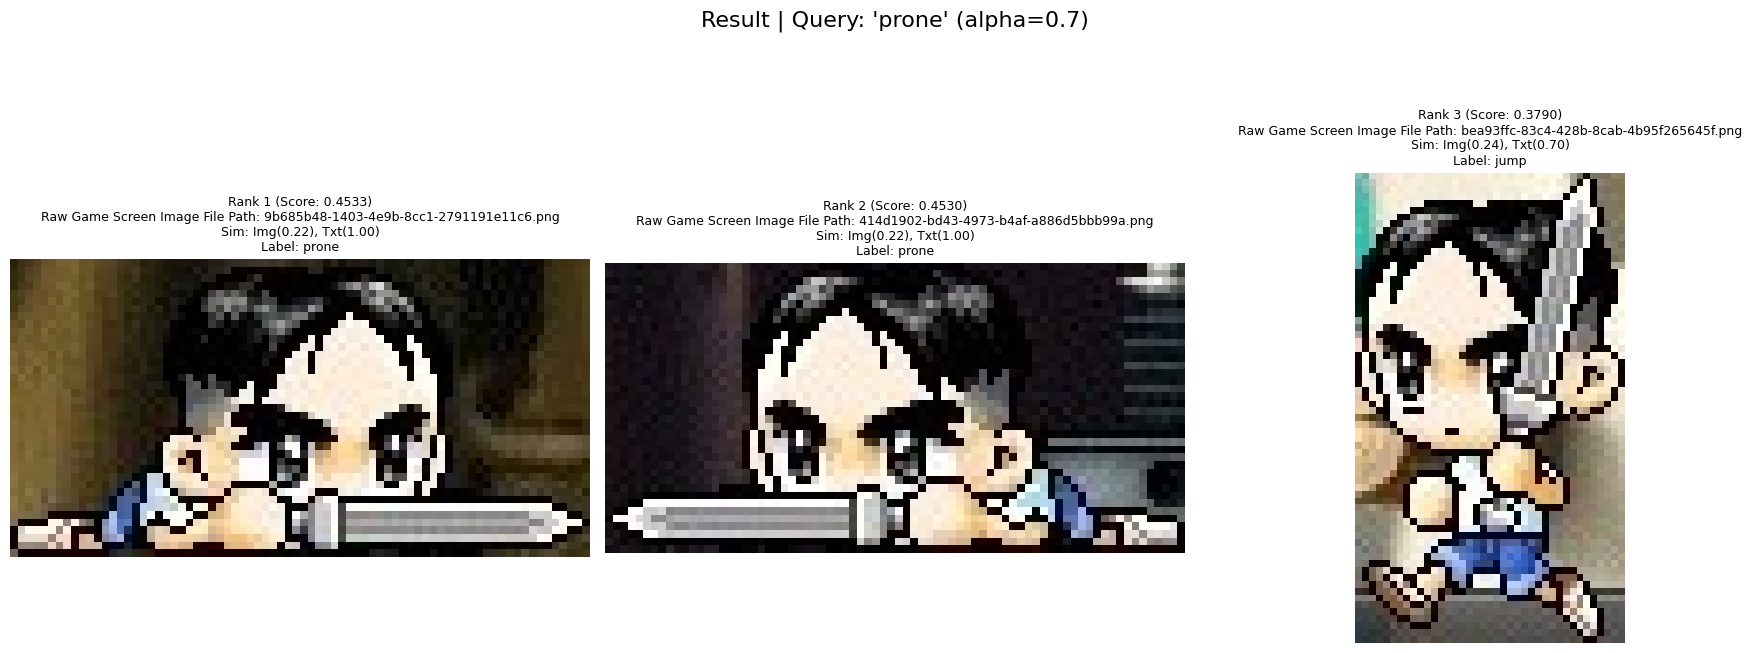

In [ ]:
# 실험 4 : 쿼리를 영어로 입력하고 이미지 유사도 비중 alpha를 높임
search_re_ranker("prone", k=3, alpha=0.7)

결과 분석 : 실험 3과 같이 쿼리 텍스트가 라벨과 동일하므로 TxtSim이 높게 나오지만, 텍스트 데이터의 유사도 비중을 0.3으로 낮게 주어
CLIP 모델이 취약한 2d 이미지 데이터 유사도 비중이 커진만큼 score가 0.4 대로 낮아진 것을 알 수 있음.

## 실험별 정량 결과 비교

| 구분 | 쿼리 언어 | 특이사항 | 이미지 데이터 유사도 가중치 (α) | ImgSim | TxtSim | 최종 Score |
|------|-----------|----------|------------|--------|--------|------------|
| 실험 1 | 한국어 | 간단명료한 자연어 | 0.3 | 0.2대 | 0.59∼0.7 | 0.5대 |
| 실험 2 | 한국어 | 미사여구 추가 | 0.3 | (예시 1과 유사) | 0.5대 | 예시 1 대비 0.1%p 하락 |
| 실험 3 | 영어 | 라벨과 완벽 일치 | 0.3 | (낮음) | 1.0에 근접 | 0.7대 |
| 실험 4 | 영어 | 라벨과 완벽 일치 | 0.7 (추정) | (낮음) | 1.0에 근접 | 예시 3 대비 하락 |


① 2D 픽셀 이미지 데이터의 특수성
    
- 모든 예시에서 $ImgSim$이 $0.2$대로 매우 낮게 측정 됨. 
    
- 이는 실사 이미지 기반으로 사전 학습된 Jina-CLIP-v2(또는 일반 CLIP) 모델이 메이플스토리와 같은 2D 픽셀 캐릭터의 시각적 특징을 추출하는 데 취약함을 입증

② 텍스트 임베딩의 성능 및 다국어 지원 
    
- 한국어 쿼리에서도 $ TxtSim $이 $0.59$이상을 상회하며 안정적인 수치를 보임.
    
- 영어 쿼리가 라벨명과 일치할 경우 $TxtSim$이 $1$에 근접하는 점을 통해, Jina-CLIP-v2의 텍스트-텍스트 매칭 성능이 매우 강력함을 알 수 있음.

③ 쿼리 구성 및 가중치의 영향(추정)
    
- 미사여구의 영향: 쿼리에 의미 없는 수식어가 포함될 경우 텍스트 벡터의 집중도가 분산되어 $TxtSim$이 약 $0.2$ 가량 하락하고 최종 점수($Score$)에도 부정적인 영향을 미침.
    
- 가중치($\alpha$)의 역할: 시각적 유사도 비중($\alpha$)을 높일수록 모델의 취약점인 이미지 데이터의 영향력이 커져 전체 시스템의 신뢰도(Score)가 하락하는 경향을 보임.